# Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from arch.unitroot import PhillipsPerron as pp
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importando base de dados formatada

## 1.1 Tratando os dados internos

In [2]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d')

train_data  = pd.read_csv('data/transformed/DADO_TREINO_UBE_48_12_univariate.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
test_data = pd.read_csv('data/transformed/DADO_TESTE_UBE_48_12_univariate.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)

data = pd.concat([train_data, test_data], axis=0)

data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data

,value,date
index,,
1973-01-01,337.0,1973-01-01
1973-01-02,361.0,1973-01-02
1973-01-03,476.0,1973-01-03
1973-01-04,765.0,1973-01-04
1973-01-05,999.0,1973-01-05
...,...,...
2019-12-17,281.0,2019-12-17
2019-12-18,299.0,2019-12-18
2019-12-19,312.0,2019-12-19


In [3]:
data = data['1/1/2017 12:00:00 AM':]

# 2. SARIMA

## 2.1 Tratando os dados internos

In [4]:
split_date = '1/1/2019 12:00:00 AM'
train = data[ : split_date]
test  = data[split_date : ]

train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)

series

index
2017-01-01    482.0
2017-01-02    458.0
2017-01-03    435.0
2017-01-04    407.0
2017-01-05    384.0
              ...  
2019-12-17    281.0
2019-12-18    299.0
2019-12-19    312.0
2019-12-20    311.0
2019-12-21    295.0
Name: value, Length: 1086, dtype: float64

## 2.2 Métodos para treinamento

In [5]:
# Mostrar previsão de acordo com os dados originais
def plot_forecasts(series, forecasts, test):
    plt.plot(series, color='blue')
    plt.plot(forecasts, color='red')
    plt.show()

# Avaliação de erro do SARIMA
def evaluate_forecasts(test, forecasts, n_steps):
    sum_rmse = 0
    sum_mape = 0
    for i in range(n_steps):
        ypred_ts = [forecast[i] for forecast in forecasts]
        ytrue_ts = test[i:len(ypred_ts)+i]
        # Calculando os erros
        mape = mean_absolute_percentage_error(ytrue_ts, ypred_ts)*100
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        sum_rmse += rmse
        sum_mape += mape
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape}")

    # média dos erros
    print(f"Média do RMSE: {sum_rmse/n_steps}")
    print(f"Média do MAPE: {sum_mape/n_steps}")

# Treinamento de previsão por SARIMA por multiplos passos
def sarima_forecast(train, config, n_steps):
    order, s_order, trend = config
    # Definindo e moldando o modelo
    # trend=trend
    model = SARIMAX(train, order=order, seasonal_order=s_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()

    # Fazendo previsão com multiplos passos
    yhat = model_fit.predict(len(train), len(train)+n_steps-1)
    yhat_list = [value for value in yhat]

    return yhat_list

## 2.3 Treinamento e resultado

In [6]:
test = test
series = series
train = [x for x in train]

n_steps = 7

# Ordem de tendencial
p_param = 1
d_param = 0
q_param = 0
# Periodo e ordem sazonal
P_param = 1
D_param = 0
Q_param = 0
m_param = 7
# Tipo de tendencia
t_params = 'c'  # outros tipos: 'n','c','t','ct'
# configuração
config = [(p_param,d_param,q_param), (P_param,D_param,Q_param,m_param), t_params]

# lista para armazenar os paços de predição e a quantidade de predições a frente
forecasts = list()
n_forecasts = len(test) - n_steps + 1
# n_forecasts = 1

for i in range(n_forecasts):
    # prevendo valor por sarima
    yhat = sarima_forecast(train, config, n_steps)
    # adicionando valor de predição a lista
    forecasts.append(yhat)
    # Adicionando valor de previsão pelo treino para o proximo loop
    obs = test[i]
    train.append(obs)


In [7]:
def Extract(lst):
    return list(list(zip(*lst))[0])

def avg(lst):
    return list(map(np.mean, lst))

forecast_series = pd.Series(Extract(forecasts), index=test.index[:len(forecasts)])
forecast_series

index
2019-01-01    352.536841
2019-01-02    349.268182
2019-01-03    381.432631
2019-01-04    415.181026
2019-01-05    441.871378
                 ...    
2019-12-11    287.445801
2019-12-12    268.958520
2019-12-13    254.066373
2019-12-14    245.128967
2019-12-15    240.889418
Length: 349, dtype: float64

t+1 RMSE: 22.15295045366087 | MAPE: 3.53876774278718
t+2 RMSE: 41.57967735288624 | MAPE: 6.430692046537437
t+3 RMSE: 58.739838869690736 | MAPE: 8.948311218999967
t+4 RMSE: 73.34937547203336 | MAPE: 10.922519043955353
t+5 RMSE: 85.79240358532645 | MAPE: 12.668005296366559
t+6 RMSE: 96.36129177369486 | MAPE: 14.277362923357066
t+7 RMSE: 105.50292651471865 | MAPE: 15.710504254903945
Média do RMSE: 69.06835200314445
Média do MAPE: 10.356594646701073


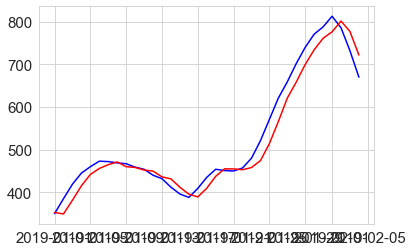

In [8]:
# Avaliação da previsão
evaluate_forecasts(test, forecasts, n_steps)
# Mostrar previsão
limit = int(len(test)*0.1)
plot_forecasts(test[:limit], forecast_series[:limit], test)